## Singapore Rainfall data for the location (1.30◦N,103.68◦E), collected in year 2010 from ground-based weather station with high resolution.
---
**AIM** - To understands the relationship between the precipitation estimates from various sensors: ground-based weather stations (PRAT), publicly available weather gauge data, satellite-based, and merged products. The case study is Singapore in our case.

Exploratory analysis - Initial Plotting and Data Parsing.

In [1]:
%matplotlib inline
from glob import glob # For selecting multiple filenames
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import xarray as xr
import seaborn as sns # for density plots
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# Used for DTW
from scipy.spatial.distance import cdist
from tslearn import metrics
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
# from datetime import datetime
style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (16,5) # For Increasing Size of graph

In [2]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# Data Importing
---

* For **PRAT - PRivate and Agile Temporally data**, which is the ground based station with high resolution

In [3]:
# Dataframe for PRAT--> PRivate and Agile Temporally data
prat_rainfall_df = pd.read_csv("data/imagerdata.csv", header=None, names=["day", "hour", "minute", "rainfall_rate"])

* For **CHIRPS** - Satellite based public data

In [4]:
chirps_dataset = xr.open_dataset('data/chirps-2010.nc') # open the dataset using xarray

* From **Global Precipitation Measurement (GPM)**

In [5]:
gpm_dataset = xr.open_dataset('data/singaporeIMERG.nc')

* From **Ground based Gauge Station by Meteorological Service Singapore (MSS)**

In [6]:
# Import using glob
filenames = glob("data/daily_*.csv")
gauge_station_df = pd.concat([pd.read_csv(filename, encoding= 'unicode_escape', usecols = ['Year', 'Month', 'Day', 'Daily Rainfall Total (mm)']) 
                              for filename in filenames], axis=0)

gauge_station_df.head()

,Year,Month,Day,Daily Rainfall Total (mm)
0,2010,7,1,104.2
1,2010,7,2,18.4
2,2010,7,3,34.8
3,2010,7,4,0.0
4,2010,7,5,0.0


# Parsing the Datasets

* **Gauge Station**

Parse Year, Month and day. Convert to datetime. Set index to timestamp. Drop Year, Month and Day columns. Rename the column

In [8]:
# Semicolon is used to separate month and day, otherwise datetime is wrongly converted
gauge_station_df['timestamp'] = pd.to_datetime(gauge_station_df['Year'].astype(str) + 
                                               gauge_station_df['Month'].astype(str) + ":"+ 
                                               gauge_station_df['Day'].astype(str), format="%Y%m:%d")

gauge_station_df.set_index('timestamp', inplace=True)
gauge_station_df.drop(['Year', 'Month', 'Day'], inplace=True, axis=1)
gauge_station_df.sort_index(axis=0)
gauge_station_df.rename(columns={'Daily Rainfall Total (mm)':'rainfall_rate'}, inplace=True)

gauge_station_df.head()

,rainfall_rate
timestamp,
2010-07-01,104.2
2010-07-02,18.4
2010-07-03,34.8
2010-07-04,0.0
2010-07-05,0.0


* **CHIRPS**

In [29]:
# chirps_df = chirps_dataset['precip'].sel(time=slice('2010-01-01T00:0','2010-01-31T00:0'), longitude=103.67499, latitude=1.324997).to_dataframe()
# chirps_full_df = chirps_dataset['precip'].sel(time=slice('2010-01-01T00:0','2010-12-31T00:0'), longitude=103.67499, latitude=1.324997).to_dataframe()

monsoon_chirps = chirps_dataset.sel(time=slice('2010-06-01','2010-09-30'), 
                                    longitude=103.67499, latitude=1.324997)

* **GPM**

The Dates are not of proper format. So, need to change it to suitable python datetime object

In [10]:
gpm_dataset['time'] = gpm_dataset.indexes['time'].to_datetimeindex()

/Users/dhirajsaharia/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  """Entry point for launching an IPython kernel.


In [122]:
gpm_sampled = gpm_dataset.sel(lon=103.68, lat=1.30, method='nearest').resample(time='1D').sum()
gpm_sampled

<xarray.Dataset>
Dimensions:           (time: 365)
Coordinates:
  * time              (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31
    lon               float32 103.65
    lat               float32 1.25
Data variables:
    precipitationCal  (time) float32 5.6014466 0.62149346 ... 0.92519027

* **PRAT**

In [12]:
# append the timedelta in hours and minutes to get the full timestamp
# Using day number to create the date

prat_rainfall_df['date']=pd.to_datetime(prat_rainfall_df['day'], unit='D', origin=pd.Timestamp('2009-12-31')) 

prat_rainfall_df['timestamp'] = prat_rainfall_df['date'] + pd.to_timedelta(prat_rainfall_df['hour'].astype('str') + 
                                                                               ':' + prat_rainfall_df['minute'].astype('str') + ':00') 
prat_rainfall_df.set_index('timestamp', inplace=True)

In [14]:
prat_sampled_df = pd.DataFrame()
prat_rainfall_df['rainfall_rate'] = prat_rainfall_df['rainfall_rate']/60.0 # mm / 60

# Groupby MONTH and then taking the total daily sum
prat_sampled_df = prat_rainfall_df.resample('D').sum() 

prat_sampled_df.drop(['day', 'hour', 'minute'], axis=1, inplace=True) # Dropped the day, hour, minute columns
prat_sampled_df.head() # PRAT Data after resampling

,rainfall_rate
timestamp,
2010-01-01,18.0
2010-01-02,0.2
2010-01-03,0.2
2010-01-04,13.2
2010-01-05,0.0


# Monsoon Rainfall
---
According to [this](https://www.guidemesingapore.com/business-guides/immigration/get-to-know-singapore/weather-and-climate-in-singapore),
There is no clear-cut wet or dry season and rain is experienced every single month, usually in the afternoons and early evenings. However, there are two main monsoon seasons in Singapore: **Northeast Monsoon Season (December-March) and the Southwest Monsoon Season (June-September)**.

* Extract Monsoon Data

In [42]:
JUNE = 6
SEPT = 9
monsoon_prat = prat_sampled_df[(prat_sampled_df.index.month >= JUNE) & (prat_sampled_df.index.month <= SEPT)]
monsoon_gauge = gauge_station_df[(gauge_station_df.index.month >= JUNE) & (gauge_station_df.index.month <= SEPT)]
monsoon_gauge = monsoon_gauge.sort_index(axis=0)
monsoon_gpm = gpm_sampled.sel(time=slice('2010-06-01','2010-09-30'))

* Plot the data

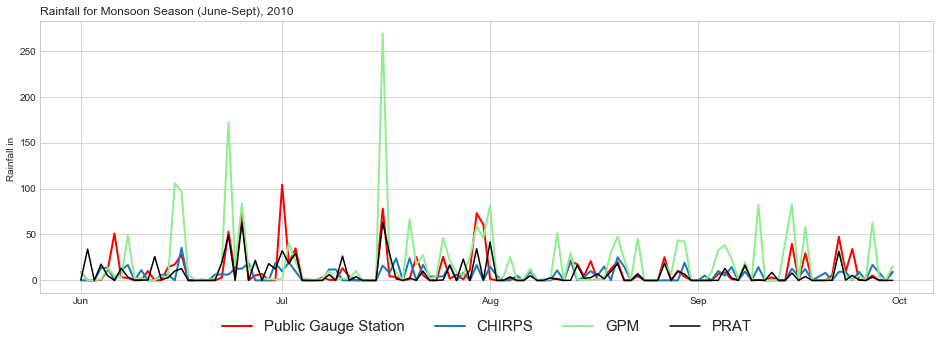

In [70]:
plt.plot(monsoon_gauge['rainfall_rate'], linewidth=2, label='Public Gauge Station', c='red')
plt.plot(monsoon_chirps['time'], monsoon_chirps['precip'], label='CHIRPS', linewidth=2)
plt.plot(monsoon_gpm['time'], monsoon_gpm['precipitationCal'], linewidth=2, label="GPM", c='lightgreen')
plt.plot(monsoon_prat['rainfall_rate'], label='PRAT', c='black')
plt.title('Rainfall for Monsoon Season (June-Sept), 2010', loc='left')
plt.ylabel("Rainfall in ")
ax = plt.gca()
locator = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(month_fmt)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, prop={'size': 15}, fontsize=15);

* Distribution Plot

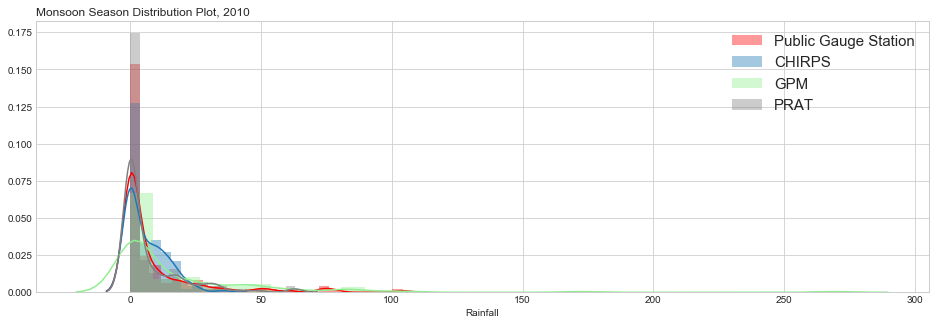

In [78]:
sns.distplot(monsoon_gauge['rainfall_rate'], hist=True, kde=True, label='Public Gauge Station', color='red')
sns.distplot(monsoon_chirps['precip'], hist=True, kde=True, label='CHIRPS')
sns.distplot(monsoon_gpm['precipitationCal'], hist=True, kde=True, label='GPM', color='lightgreen')
sns.distplot(monsoon_prat['rainfall_rate'], hist=True, kde=True, label='PRAT', color='gray')
plt.legend(fontsize=15)
plt.title('Monsoon Season Distribution Plot, 2010', loc="left")
plt.xlabel("Rainfall");

# Correlation Calculation
---
* Pearson Coefficient

In [103]:
print(f"Correlation of PRAT with Gauge station data {monsoon_prat.corrwith(monsoon_gauge, method='pearson').values}")
print(f"Correlation of PRAT with GPM dataset {monsoon_prat.corrwith(monsoon_gpm['precipitationCal'].to_series(), method='pearson').values}")
print(f"Correlation of PRAT with CHIRPS {monsoon_prat.corrwith(monsoon_chirps['precip'].to_series(), method='pearson').values}")      

Correlation of PRAT with Gauge station data [0.61671942]
Correlation of PRAT with GPM dataset [0.59278394]
Correlation of PRAT with CHIRPS [0.27483112]


* Kling-Gupta Efficiency

In the computation of this index, there are three main components involved:

1) r : the Pearson product-moment correlation coefficient. Ideal value is r=1

2) Beta : the ratio between the mean of the simulated values and the mean of the observed ones. Ideal value is Beta=1

3) vr : variability ratio, which could be computed using the standard deviation (Alpha) or the coefficient of variation (Gamma) of sim and obs, depending on the value of method

3.1) Alpha: the ratio between the standard deviation of the simulated values and the standard deviation of the observed ones. Ideal value is Alpha=1.

3.2) Gamma: the ratio between the coefficient of variation (CV) of the simulated values to the coefficient of variation of the observed ones. Ideal value is Gamma=1. 

* Monthly Correlation values for Monsoon season

In [109]:
pd.merge(
    monsoon_prat, monsoon_gauge, 
    on='timestamp'
).resample('1M')[['rainfall_rate_x', 'rainfall_rate_y']].corr().groupby(level=0).first()

,rainfall_rate_x,rainfall_rate_y
timestamp,,
2010-06-30,1.0,0.609486
2010-07-31,1.0,0.659257
2010-08-31,1.0,0.397254
2010-09-30,1.0,0.729701


# Scatter Plots of PRAT with other datasets
---

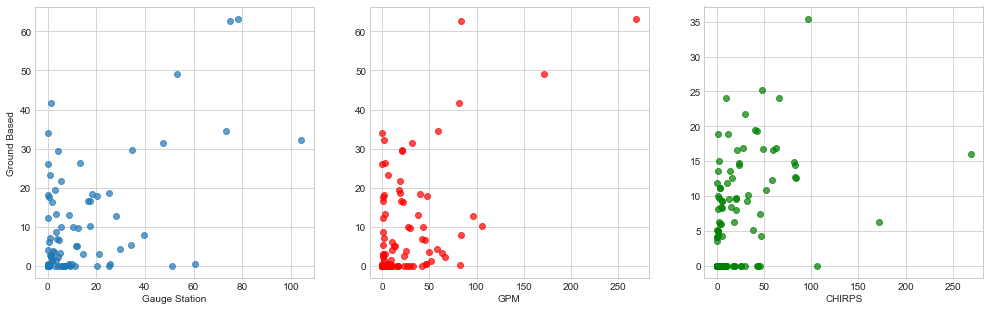

In [104]:
plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plt.scatter(monsoon_gauge['rainfall_rate'], monsoon_prat['rainfall_rate'], alpha=0.7)
plt.xlabel('Gauge Station')
plt.ylabel('Ground Based')
plt.subplot(1,3,2)
plt.scatter(monsoon_gpm['precipitationCal'], monsoon_prat['rainfall_rate'], alpha=0.7, c='r')
plt.xlabel('GPM')
plt.subplot(1,3,3)
plt.scatter(monsoon_gpm['precipitationCal'], monsoon_chirps['precip'], alpha=0.7, c='g')
plt.xlabel('CHIRPS');

# Dynamic Time Warping (DTW) -
---
To be checked later

In [121]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
prat_scaled = scaler.fit_transform(monsoon_prat['rainfall_rate'])
gauge_scaled = scaler.fit_transform(monsoon_gauge['rainfall_rate'])
path_gauge, sim_gauge = metrics.dtw_path(prat_scaled.ravel(), gauge_scaled.ravel())
path_gpm, sim_gpm = metrics.dtw_path(monsoon_prat['rainfall_rate'], monsoon_gpm['precipitationCal'])
print(f"DTW similarity score between ground based and gauge station is {sim_gauge}")
print(f"DTW similarity score between ground based and GPM is {sim_gpm}")

DTW similarity score between ground based and gauge station is 5.29914986793192
DTW similarity score between ground based and GPM is 301.54917684163183


## Delete Later

In [18]:
# daily_statistics_df = pd.DataFrame()
# monthly_statistics_df = pd.DataFrame()
# daily_statistics_df['daily_total_rate'] = rainfall_df.rainfall_rate.resample('D').sum()
# daily_statistics_df['daily_mean_rate'] = rainfall_df.rainfall_rate.resample('D').mean()
# monthly_statistics_df['monthly_total_rate'] = rainfall_df.rainfall_rate.resample('M').sum()
# monthly_statistics_df['monthly_mean_rate'] = rainfall_df.rainfall_rate.resample('M').mean()